### Goal: train RNN network on single trial data (not trial averaged)

In [12]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("../../")

import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import os
import mat73

import pyaldata as pyal
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import CCA
from tools.curbd import curbd
import pylab
from tools.dsp.preprocessing import preprocess

np.random.seed(44)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
data_dir = "/data/bnd-data/raw/M044/M044_2024_12_04_09_30"
fname = os.path.join(data_dir, "M044_2024_12_04_09_30_pyaldata_0.mat")

df = pyal.mat2dataframe(fname, shift_idx_fields=True)

field values_before_camera_trigger could not be converted to int.
field idx_before_camera_trigger could not be converted to int.
array field all_imec0_KSLabel could not be converted to int.


### PROCESSING DATAFRAME

In [14]:
df_ = preprocess(df, only_trials=True)
df_ = pyal.select_trials(df_, "idx_trial_end > 30365")  # Remove first 5 minutes because the switch was off

/home/zms24/.conda/envs/zofia_earthquake_env/earthquake-analysis/PyalData/pyaldata/firing_rates.py:108: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn(


Combined every 3 bins
Resulting all_imec0_spikes ephys data shape is (NxT): (449, 133)


In [15]:
df_.head()

,animal,session,trial_id,trial_name,trial_length,bin_size,idx_trial_start,idx_trial_end,idx_CPI,values_before_camera_trigger,...,idx_sol_on,idx_earthquake_duration,idx_session_timer,all_imec0_chan_best,all_imec0_unit_guide,all_imec0_KSLabel,all_imec0_spikes,all_imec0_rates,sol_level_id,sol_contra_ipsi
0,M044,M044_2024_12_04_09_30,82,trial,401,0.03,30233,30366,[],[],...,66,[],[],"[0, 0, 1, 1, 1, 1, 1, 2, 2, 3, 3, 3, 4, 5, 5, ...","[[0, 2], [4, 1], [5, 3], [6, 1], [8, 1], [9, 2...","[good, good, good, mua, good, good, good, good...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.21239205, 0.0, 0.0, 2.798774, 0.0, 0....",1,1
1,M044,M044_2024_12_04_09_30,84,trial,401,0.03,30399,30533,[],[],...,66,[],[],"[0, 0, 1, 1, 1, 1, 1, 2, 2, 3, 3, 3, 4, 5, 5, ...","[[0, 2], [4, 1], [5, 3], [6, 1], [8, 1], [9, 2...","[good, good, good, mua, good, good, good, good...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.91444397, 0....",1,1
2,M044,M044_2024_12_04_09_30,86,trial,401,0.03,30633,30766,[],[],...,66,[],[],"[0, 0, 1, 1, 1, 1, 1, 2, 2, 3, 3, 3, 4, 5, 5, ...","[[0, 2], [4, 1], [5, 3], [6, 1], [8, 1], [9, 2...","[good, good, good, mua, good, good, good, good...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[25.524176, 2.7990935, 0.0, 0.0, 0.0, 0.00031...",0,1
3,M044,M044_2024_12_04_09_30,88,trial,401,0.03,30933,31066,[],[],...,66,[],[],"[0, 0, 1, 1, 1, 1, 1, 2, 2, 3, 3, 3, 4, 5, 5, ...","[[0, 2], [4, 1], [5, 3], [6, 1], [8, 1], [9, 2...","[good, good, good, mua, good, good, good, good...","[[1.4142135623730951, 1.0, 0.0, 0.0, 0.0, 0.0,...","[[18.313324, 13.161868, 0.0, 0.003973114, 0.0,...",1,0
4,M044,M044_2024_12_04_09_30,90,trial,401,0.03,31099,31233,[],[],...,66,[],[],"[0, 0, 1, 1, 1, 1, 1, 2, 2, 3, 3, 3, 4, 5, 5, ...","[[0, 2], [4, 1], [5, 3], [6, 1], [8, 1], [9, 2...","[good, good, good, mua, good, good, good, good...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.034771092, 0.0, 0.0, 0.0, 0.24716315,...",0,0


In [16]:
# Separate columns of 'all_spikes' to M1 and Dls (dorsolateral striatum)
brain_areas = ["M1", "Dls"]
df_["M1_rates"] = [df_["all_imec0_rates"][i][:,300:] for i in range(len(df_))]
df_["Dls_rates"] = [df_["all_imec0_rates"][i][:,0:300] for i in range(len(df_))]

# perturbation time
perturbation_time = df_.idx_sol_on[0]

# solenoid angles
sol_angles: list = df_.sol_level_id.unique()
sol_angles.sort()

### CONCATINATE ALL TRIALS

In [17]:
df_concat_trials = pyal.concat_trials(df_, signal = "all_imec0_rates")

### PLOT RNN INPUT

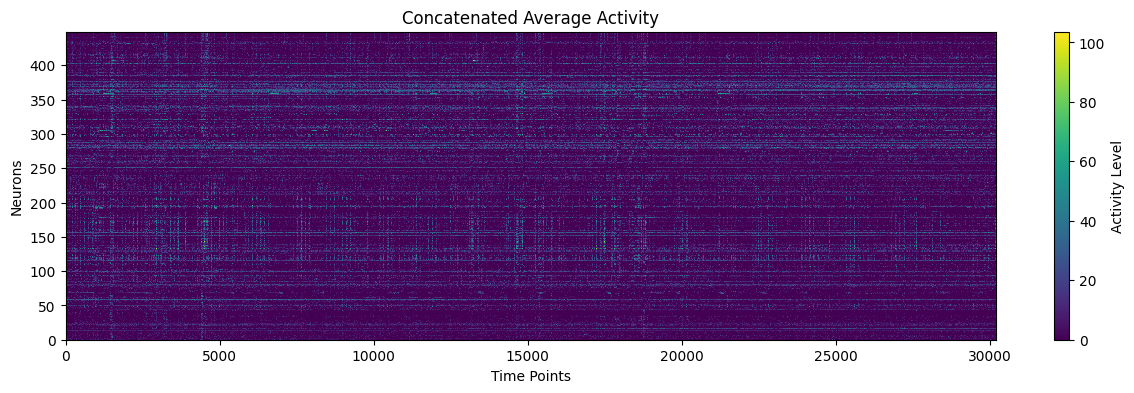

In [18]:
plt.figure(figsize=(15, 4))  # Set figure size
plt.pcolormesh(df_concat_trials.T)
plt.colorbar(label='Activity Level')
plt.title('Concatenated Average Activity')
plt.xlabel('Time Points')
plt.ylabel('Neurons')
plt.show()

SETTING UP VARIABLES FOR RNN

In [ ]:
if df_["M1_rates"][0].shape[0] == df_["Dls_rates"][0].shape[0] == df_["all_imec0_rates"][0].shape[0]:
    trial_len = df_["Dls_rates"][0].shape[0]
else:
    print(f"Variable trial length!")

reset_points = []
for i in range(len(df_)):
    reset_points.append(i*trial_len)
# new change

In [21]:
activity = np.transpose(df_concat_trials)
Na = df_.M1_rates[1].shape[1]
Nb = df_.Dls_rates[1].shape[1]
print(Na, Nb)

regions = [['M1', np.arange(0, Na)], ['Dls', np.arange(Na, Na + Nb)]]
regions = np.array(regions, dtype=object)
print(f"Building {len(regions)} region RNN network")
print(f"Regions: {regions[:, 0]} with {Na} neurons for {regions[0,0]} and {Nb} neurons for {regions[1,0]}.\n")

149 300
Building 2 region RNN network
Regions: ['M1' 'Dls'] with 149 neurons for M1 and 300 neurons for Dls.



In [27]:
model = curbd.trainMultiRegionRNN(activity,
                                  dtData=df_.bin_size[0],
                                  dtFactor=1,
                                  tauRNN = 0.2,
                                  ampInWN= 0.001,
                                  g = 1.5,
                                  regions=regions,
                                  nRunTrain=200,
                                  verbose=True,
                                  plotStatus=False,
                                  nRunFree=1,
                                  resetPoints=reset_points)

KeyboardInterrupt: 